#### 集成学习
1. 如果你随机向几千个人询问一个复杂问题，然后汇总他们的回答。在许多情况下，你会发现，这个汇总的回答比专家的回答还要好，这被称为群体智慧。同样，如果你聚合一组预测器（比如分类器或回归器）的预测，得到的预测结果也比最好的单个预测器要好。这样的一组预测器称为集成，所以这种技术也被称为集成学习，而一个集成学习算法则被称为集成方法

2. 例如，你可以训练一组决策树分类器，每一棵树都基于训练集不同的随机子集进行训练。做出预测时，你只需要获得所有树各自的预测，然后给出得票最多的类别作为预测结果，这样一组决策树的集成被称为随机森林

3. 常见的集成方法：bagging、boosting、stacking、随机森林

#### 投票分类器
1. 假设你已经训练好了一些分类器，每个分类器的准确率约为80%。大概包括一个逻辑回归分类器、一个SVM分类器、一个随机森林分类器、一个K-近邻分类器，或许还有更多（见图7-1）​。这时，要创建出一个更好的分类器，最简单的办法就是聚合每个分类器的预测，然后将得票最多的结果作为预测类别。这种大多数投票分类器被称为**硬投票分类器**

    - <img src='./images/集成学习预测器.png'>
    - <img src='./images/集成学习硬投票器.png'>

2. 事实上，即使每个分类器都是弱学习器（意味着它仅比随机猜测好一点）​，通过集成依然可以实现一个强学习器（高准确率）​，只要有足够大数量并且足够多种类的弱学习器即可
3. 当预测器尽可能**互相独立**时，集成方法的效果最优。获得多种分类器的方法之一就是使用不同的算法进行训练。这会增加它们犯不同类型错误的机会，从而提升集成的准确率。
4. 如果所有分类器都能够估算出类别的概率（即有predict_proba（​）方法）​，那么你可以将概率在所有单个分类器上平均，然后让Scikit-Learn给出平均概率最高的类别作为预测。这被称为软投票法。通常来说，它比硬投票法的表现更优，因为它给予那些高度自信的投票更高的权重。而所有你需要做的就是用voting="soft"代替voting="hard"，并确保所有分类器都可以估算出概率

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.904


In [4]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [5]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


#### bagging(boostrap aggregating)和pasting
1. 前面提到，获得不同种类分类器的方法之一是使用不同的训练算法。还有另一种方法是每个预测器使用的算法相同，但是在不同的训练集随机子集上进行训练
2. bagging和pasting都允许训练实例在多个预测器中被多次采样，但是只有bagging允许训练实例被同一个预测器多次采样
    - <img src='./images/bagging_pasting.png'>
3. 一旦预测器训练完成，集成就可以通过简单地聚合所有预测器的预测来对新实例做出预测。聚合函数通常是统计法（即最多数的预测与硬投票分类器一样）用于分类，或是平均法用于回归。每个预测器单独的偏差都高于在原始训练集上训练的偏差(因为只使用了样本的一部分)，但是通过聚合，同时降低了偏差和方差。总体来说，最终结果是，与直接在原始训练集上训练的单个预测器相比，集成的偏差相近，但是方差更低
4. 参数n_jobs用来指示Scikit-Learn用多少CPU内核进行训练和预测（-1表示让Scikit-Learn使用所有可用内核）,​如果你想使用pasting，只需要设置bootstrap=False即可;如果基本分类器可以估计类别概率（如果它具有predict_proba（​）方法）​，则BaggingClassifier自动执行**软投票**而不是硬投票，在决策树分类器中就是这种情况

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,max_samples=100,bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
# 使用单个决策树

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier()

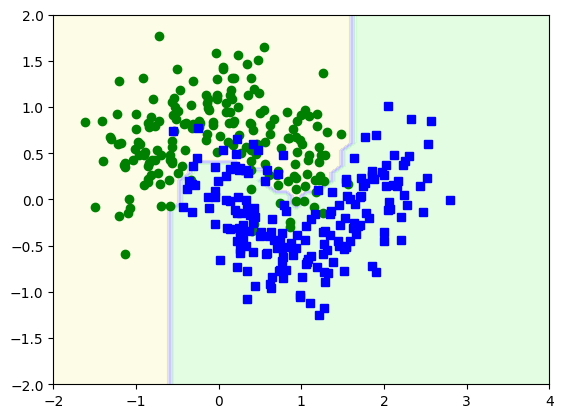

In [8]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf,X,y, axes=[0,7.5,0,3]):
    xs = np.linspace(axes[0], axes[1])
    ys = np.linspace(axes[2],axes[3])
    x1,x2 = np.meshgrid(xs,ys)
    # 对网格中的每一个点进行预测
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1,x2,y_pred,alpha=0.3, cmap=custom_cmap)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "go")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")

axes = [-2,4,-2,2]

plot_decision_boundary(bag_clf, X_train,y_train,axes)

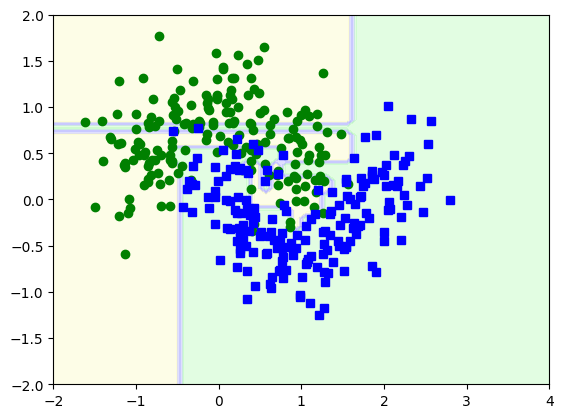

In [9]:
# 使用单个树预测的结果
plot_decision_boundary(tree_clf,X_train,y_train,axes)

#### 包外评估
1. 对于任意给定的预测器，使用bagging，有些实例可能会被采样多次，而有些实例则可能根本不被采样。BaggingClassifier默认采样m个训练实例，然后放回样本（bootstrap=True）​，m是训练集的大小。这意味着对每个预测器来说，平均只对63%的训练实例进行采样(根据采样的概率公式而得)，剩余37%未被采样的训练实例称为**包外（oob）实例**。注意，对所有预测器来说，这是不一样的37%。

2. 由于预测器在训练过程中从未看到oob实例，因此可以在这些实例上进行评估，而无须单独的验证集。你可以通过平均每个预测器的oob评估来评估整体。

3. 在Scikit-Learn中，创建BaggingClassifier时，设置oob_score=True就可以请求在训练结束后自动进行包外评估

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
   bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [11]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.896

In [12]:
bag_clf.oob_decision_function_

array([[0.37714286, 0.62285714],
       [0.37078652, 0.62921348],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09195402, 0.90804598],
       [0.36170213, 0.63829787],
       [0.00613497, 0.99386503],
       [0.99438202, 0.00561798],
       [0.96969697, 0.03030303],
       [0.78947368, 0.21052632],
       [0.        , 1.        ],
       [0.8045977 , 0.1954023 ],
       [0.84375   , 0.15625   ],
       [0.96428571, 0.03571429],
       [0.04494382, 0.95505618],
       [0.        , 1.        ],
       [0.97282609, 0.02717391],
       [0.94329897, 0.05670103],
       [1.        , 0.        ],
       [0.01630435, 0.98369565],
       [0.38202247, 0.61797753],
       [0.91866029, 0.08133971],
       [1.        , 0.        ],
       [0.95628415, 0.04371585],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.63218391, 0.36781609],
       [0.

#### 随机补丁和随机子空间
1. BaggingClassifier类也支持对特征进行采样。采样由两个超参数控制：max_features和bootstrap_features。

2. 这对于处理高维输入（例如图像）特别有用。对训练实例和特征都进行抽样，这称为**随机补丁方法**

3. 而保留所有训练实例（即bootstrap=False并且max_samples=1.0）但是对特征进行抽样（即bootstrap_features=True并且/或max_features<1.0）​，这被称为**随机子空间法**

#### 随机森林
1. 随机森林[1]是决策树的集成，通常用bagging（有时也可能是pasting）方法训练，训练集大小通过max_samples来设置

2. 除了先构建一个BaggingClassifier然后将其传输到DecisionTreeClassifier，还有一种方法就是使用RandomForestClassifier类，这种方法更方便，对决策树更优化[2]（同样，对于回归任务也有一个RandomForestRegressor类

3. 除少数例外，RandomForestClassifier具有DecisionTreeClassifier的所有超参数（以控制树的生长方式）​，以及BaggingClassifier的所有超参数来控制集成本身[3]。

4. 随机森林在树的生长上引入了更多的随机性：分裂节点时不再是搜索最好的特征（见第6章）​，而是在一个随机生成的特征子集里搜索最好的特征。这导致决策树具有更大的多样性，​（再一次）用更高的偏差换取更低的方差
    - 游戏的规则是，你需要在一个大森林中寻找一条通往终点的路。在游戏的早期，你可以选择任何一条你认为可能正确的路。这就像随机森林中的树在生长时，不是选择最好的特征来分裂节点，而是随机选择一部分特征来进行分裂。这样做的好处是，你可以探索更多的可能性，就像你在森林中探索更多的路径一样。然而，这种随机性也可能会导致你走错路，就像随机森林中的树可能会产生错误的决策样。但是，只要你的探索足够多，你最终找到正确路的可能性就会大大增加。这就是为什么随机森林虽然具有更大的多样性，可能会产生更高的偏差(即更可能做出错误的决策)，但也可能产生更低的方差(即更可能做出正确的

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter='random', max_leaf_nodes=16), n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

##### 极端随机树
1. 在随机森林里单棵树的生长过程中，每个节点在分裂时仅考虑到了一个随机子集所包含的特征。如果我们对每个特征使用随机阈值，而不是搜索得出的最佳阈值（如常规决策树）​，则可能让决策树生长得更加随机。

2. 这种极端随机的决策树组成的森林称为极端随机树集成[4]（或简称Extra-Trees）​。同样，它也是以更高的偏差换取了更低的方差

3. 极端随机树训练起来比常规随机森林要快很多，因为在每个节点上找到每个特征的最佳阈值是决策树生长中最耗时的任务之一。

4. 通常来说，很难预先知道一个RandomForestClassifier类是否会比一个ExtraTreesClassifier类更好或是更差。唯一的方法是两种都尝试一遍，然后使用交叉验证（还需要使用网格搜索调整超参数）进行比较

#### 特征重要性
1. 随机森林的另一个好特性是它们使测量每个特征的相对重要性变得容易，该特征的树节点平均（在森林中的所有树上）减少不纯度的程度来衡量该特征的重要性

2. 随机森林非常便于你快速了解哪些特征是真正重要的，特别是在需要执行特性选择时

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09288926595429046
sepal width (cm) 0.022528294078828066
petal length (cm) 0.45792177630992575
petal width (cm) 0.42666066365695576


**Code to generate Figure 7–6. MNIST pixel importance (according to a Random Forest classifier):**

In [16]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

/root/anaconda3/envs/landmark/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(random_state=42)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt


def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.hot,interpolation='nearest')
    plt.axis('off')

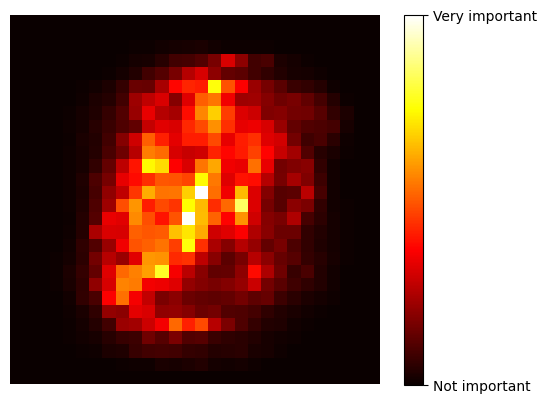

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar =plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important','Very important'])
plt.show()

#### 提升法
1. 提升法（boosting，最初被称为假设提升）是指可以将几个弱学习器结合成一个强学习器的任意集成方法。大多数提升法的总体思路是循环训练预测器，每一次都对其前序做出一些改正

#### AdaBoost
1. 新预测器对其前序进行纠正的方法之一就是更多地关注前序欠拟合的训练实例，从而使新的预测器不断地越来越专注于难缠的问题，这就是AdaBoost使用的技术。

2. 例如，当训练AdaBoost分类器时，该算法首先训练一个基础分类器（例如决策树）​，并使用它对训练集进行预测。然后，该算法会增加分类错误的训练实例的相对权重。然后，它使用更新后的权重训练第二个分类器，并再次对训练集进行预测，更新实例权重
    - <img src="./images/Adaboost.png">

3. 这种依序学习技术有一个重要的缺陷就是无法并行（哪怕只是一部分）​，因为每个预测器只能在前一个预测器训练完成并评估之后才能开始训练。因此，在扩展方面，它的表现不如bagging和pasting方法.
    - <img src="./images/Adaboost_float.png">

4. 在对分类器进行集成的时候，若分类器的误差越小则权重越大

5. 如果Adaboost过拟合，则可以减少估算器的数量，或是提高基础估算其的正则化参数

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,algorithm='SAMME.R', learning_rate=0.5
)

ada_clf.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [6]:
from sklearn.metrics import accuracy_score
y_pred = ada_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.896

#### 梯度提升
1. 梯度提升也是逐步在集成中添加预测器，每一个都对其前序做出改正。不同之处在于，它不是像AdaBoost那样在每个迭代中调整实例权重，而是让新的预测器针对前一个预测器的残差进行拟合。

2. 超参数learning_rate对每棵树的贡献进行缩放。如果你将其设置为低值，比如0.1，则需要更多的树来拟合训练集，但是预测的泛化效果通常更好，这是一种被称为收缩的正则化技术

3. 要找到树的最佳数量，可以使用提前停止法（参见第4章）要实现提前停止法，不一定需要先训练大量的树，然后再回头找最优的数字，还可以提前停止训练。设置warm_start=True，当fit（​）方法被调用时，Scikit-Learn会保留现有的树，从而允许增量训练

4. GradientBoostingRegressor类还可以支持超参数subsample，指定用于训练每棵树的实例的比例。例如，如果subsample=0.25，则每棵树用25%的随机选择的实例进行训练。现在你可以猜到，这也是用更高的偏差换取了更低的方差，同时在相当大的程度上加速了训练过程。这种技术被称为随机梯度提升。

In [33]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [36]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,  y)

DecisionTreeRegressor(max_depth=2)

In [38]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)


DecisionTreeRegressor(max_depth=2)

In [39]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [41]:
X_new = np.array([[0.8]])

In [42]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))
print(y_pred)

[0.75026781]


训练GBRT集成有个简单的方法，就是使用Scikit-Learn的GradientBoostingRegressor类。与RandomForestRegressor类似，它具有控制决策树生长的超参数（例如max_depth、min_samples_leaf等）​，以及控制集成训练的超参数，例如树的数量（n_estimators）​。以下代码可创建上面的集成：

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train,y_val = train_test_split(X,y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=60, random_state=42)

In [45]:
min_error = np.min(errors)

In [46]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

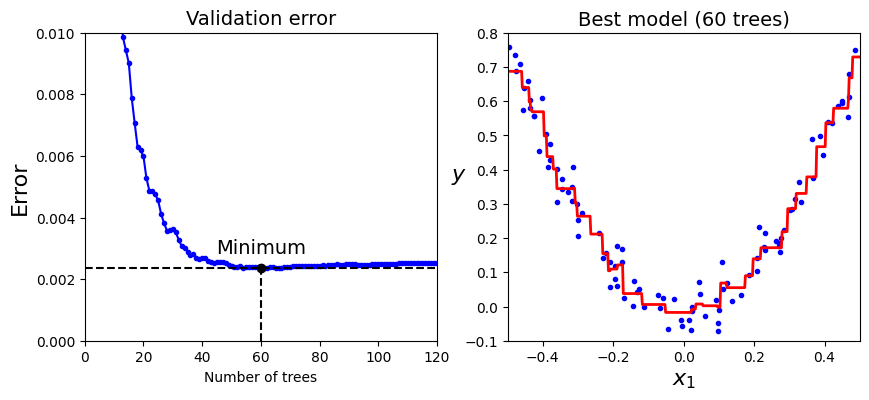

In [48]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

以下代码会在验证误差连续5次迭代未改善时，直接停止训练

In [49]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1,120):
    gbrt.n_estimators_ = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

流行的Python库XGBoost（该库代表Extreme Gradient Boosting）中提供了梯度提升的优化实现，该软件包最初是由Tianqi Chen作为分布式（深度）机器学习社区（DMLC）的一部分开发的，其开发目标是极快、可扩展和可移植。实际上，XGBoost通常是ML竞赛中获胜的重要组成部分。XGBoost的API与Scikit-Learn的非常相似：

### 堆叠法

#### 含义
1. 在构建机器学习模型的过程中，Stacking 能够有效融合多个 Predictor 的结果，是提提高模型分数的重要手段。Stacking 主要含义是，在模型预测得到的结果上，再训练一个模型，就仿佛是在原有的模型上再「堆叠」（Stacking）一个模型。这样做的直觉在于，不同的模型能够提取数据中不同的信息。由于数据的噪声，不同的模型往往会在数据的不同特征上表现很好，但是也各有表现较差的部分。Stacking 就是这样一种方法，它能够把各个模型在提取特征较好的部分给抓取出来，同时舍弃它们各自表现不好的部分，这就能够有效地优化预测结果、提高最终预测的分数了。

#### 核心步骤

1. 在训练数据上训练并使用多个模型进行预测，得到**多组预测结果**，也就是我们所说的超特征（Meta Features）；同时我们也对测试数据使用这些模型进行预测，得到测试数据的超特征。

2. 使用一个新的模型，对**这些超特征再进行训练**，训练一个从超特征**到真实值（ground-truth）的模型**；再将测试数据的超特征输入这些模型，得到最后的结果。


#### 构建模型的方法
1. 不同算法的模型，例如同时使用 SVM、Random Forest 等，使用的模型差异越大越好。所谓差异越大，如上 SVM 是线性模型的一种，而 Random Forest 则是一种 tree-based model。

2. 在不同的数据上训练的模型，例如在 kfold 中，在不同 fold 上训练的模型。

3. 基于不同随机种子的模型。注：如果在不同随机种子上该模型训练结果的差异很大，你可能需要考虑更换一个训练模型。

#### 参考资料
1. https://blog.csdn.net/weixin_46803857/article/details/128700297#1%E3%80%81Stacking%E7%9A%84%E5%9F%BA%E6%9C%AC%E6%80%9D%E6%83%B3%F0%9F%92%8D

2. https://zhuanlan.zhihu.com/p/48262572#:~:text=%E5%9C%A8%E6%9E%84%E5%BB%BA%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B%E7%9A%84%E8%BF%87%E7%A8%8B%E4%B8%AD%EF%BC%8CStacking%20%E8%83%BD%E5%A4%9F%E6%9C%89%E6%95%88%E8%9E%8D%E5%90%88%E5%A4%9A%E4%B8%AA%20Predictor,%E7%9A%84%E7%BB%93%E6%9E%9C%EF%BC%8C%E6%98%AF%E6%8F%90%E6%8F%90%E9%AB%98%E6%A8%A1%E5%9E%8B%E5%88%86%E6%95%B0%E7%9A%84%E9%87%8D%E8%A6%81%E6%89%8B%E6%AE%B5%E3%80%82%20Stacking%20%E4%B8%BB%E8%A6%81%E5%90%AB%E4%B9%89%E6%98%AF%EF%BC%8C%E5%9C%A8%E6%A8%A1%E5%9E%8B%E9%A2%84%E6%B5%8B%E5%BE%97%E5%88%B0%E7%9A%84%E7%BB%93%E6%9E%9C%E4%B8%8A%EF%BC%8C%E5%86%8D%E8%AE%AD%E7%BB%83%E4%B8%80%E4%B8%AA%E6%A8%A1%E5%9E%8B%EF%BC%8C%E5%B0%B1%E4%BB%BF%E5%9C%A8%E5%8E%9F%E6%9C%89%E7%9A%84%E6%A8%A1%E5%9E%8B%E4%B8%8A%E5%86%8D%E3%80%8C%E5%A0%86%E5%8F%A0%E3%80%8D%EF%BC%88Stacking%EF%BC%89%E4%B8%80%E4%B8%AA%E6%A8%A1%E5%9E%8B%E3%80%82

### 练习题
1. 应该可以，用集成方法
2. 硬投票：选出结果出现次数最多的最为最终分类结果；软投票：给出每个类的估算概率，然后对概率取平均，选出概率最高的类别； **软比硬更好，因为它给予那些高度自信的投票更高的权重**
3. boosting集成无法并行处理；**对于stacking只有不同层的预测器有序列关系，但是同一层之间可以并行计算**
4. 包外评估好处：充分利用数据集，且不需要手动划分训练集和测试集
5. 极端随机树分裂子节点不考虑纯度等指标，这种随机性可以增加树的多样性，就是利用偏差换取方差，一般比随机森林块
6. 可以调整树的节点，也可以增加n_estimators
7. 应该降低学习率，**采用提前停止法**

In [1]:
# 第8题
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,parser="auto")
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
# 训练集、验证集、测试集 5000， 1000， 1000
# 随机森林，极端随机数，SVM
# 硬投票，软投票

from sklearn.model_selection import train_test_split
X, y = mnist['data'], mnist['target']
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=5/7)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)
(10000, 784)


In [26]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 使用网格搜素找到合适的参数
params = {
    "n_estimators": [10,20, 50, 100, 120]
}

rnd_clf = RandomForestClassifier(bootstrap=True, n_jobs=-1, oob_score=True)

grd_clf = GridSearchCV(rnd_clf,params,cv=3, verbose=2)
grd_clf.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=10; total time=   1.7s


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=10; total time=   1.7s


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=10; total time=   1.7s


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=20; total time=   2.8s
[CV] END ....................................n_estimators=20; total time=   2.7s


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=20; total time=   2.9s
[CV] END ....................................n_estimators=50; total time=   5.8s
[CV] END ....................................n_estimators=50; total time=   6.0s
[CV] END ....................................n_estimators=50; total time=   5.7s
[CV] END ...................................n_estimators=100; total time=  11.1s
[CV] END ...................................n_estimators=100; total time=  10.5s
[CV] END ...................................n_estimators=100; total time=  10.6s
[CV] END ...................................n_estimators=120; total time=  13.4s
[CV] END ...................................n_estimators=120; total time=  12.1s
[CV] END ...................................n_estimators=120; total time=  12.4s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, oob_score=True),
             param_grid={'n_estimators': [10, 20, 50, 100, 120]}, verbose=2)

In [28]:
grd_clf.best_params_

{'n_estimators': 120}

In [29]:
from sklearn.metrics import accuracy_score
y_pred = grd_clf.predict(X_val)
accuracy_score(y_pred, y_val)

0.9667

In [24]:
rnd_clf = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [25]:
y_pred = rnd_clf.predict(X_val)
accuracy_score(y_pred, y_val)

0.9671

In [36]:
# 极端随机森林
from sklearn.ensemble import ExtraTreesClassifier

rnd_clf_random = ExtraTreesClassifier(n_estimators=120, bootstrap=True, oob_score=True, random_state=42, n_jobs=-1)

rnd_clf_random.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, n_estimators=120, n_jobs=-1,
                     oob_score=True, random_state=42)

In [14]:
y_pred = rnd_clf_random.predict(X_val)
accuracy_score(y_pred, y_val)

0.9666

[SVM的参考资料](https://zhuanlan.zhihu.com/p/134091240)

In [27]:
# SVM
from sklearn.svm import SVC

# 'ovr'表示一对多
svm_clf = SVC(C=1.0, decision_function_shape='ovr', kernel='rbf')
svm_clf.fit(X_train, y_train)

SVC()

In [30]:
y_pred = svm_clf.predict(X_val)
accuracy_score(y_pred, y_val)

0.9777

总结：感觉极端随机森林训练的速度较快前效果比较好; SVM的速度最慢，训练速度和预测速度都非常慢，但是SVM的准确度很高

In [34]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('rnd_clf',rnd_clf),('rf_r',rnd_clf_random),('svc',svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rnd_clf',
                              RandomForestClassifier(n_jobs=-1,
                                                     oob_score=True)),
                             ('rf_r',
                              ExtraTreesClassifier(bootstrap=True,
                                                   n_estimators=120, n_jobs=-1,
                                                   oob_score=True,
                                                   random_state=42)),
                             ('svc', SVC())])

In [38]:
for clf in (rnd_clf, rnd_clf_random, svm_clf, voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

RandomForestClassifier 0.9667
ExtraTreesClassifier 0.9691
SVC 0.9783
VotingClassifier 0.9739
